In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [88]:
b_img = cv2.imread('/home/tkd_010/ImageProcessing/study/image_registeration/before.png')
a_img = cv2.imread('/home/tkd_010/ImageProcessing/study/image_registeration/after.png')

b_img = cv2.cvtColor(b_img, cv2.COLOR_BGR2GRAY)
a_img = cv2.cvtColor(a_img, cv2.COLOR_BGR2GRAY)


In [12]:
b_img.shape, a_img.shape

((461, 697, 3), (461, 697, 3))

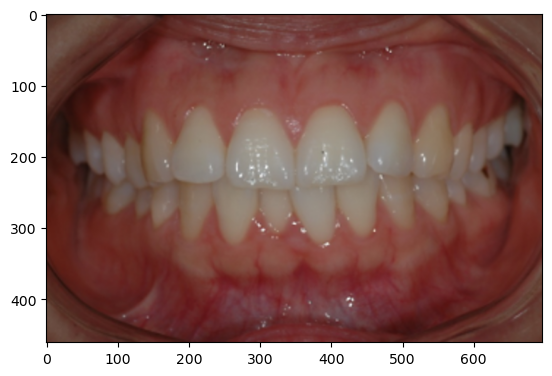

In [10]:
plt.imshow(b_img)
plt.show()

### match() 함수
: 모든 디스크립터를 하나하나 비교하여 매칭점을 찾음
- 거리를 sorting하여 거리가 긴/짧은 상위 몇 퍼센트 값만 골를 수 있음

In [37]:
# ORB - 디스크립터 추출
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(b_img, None)
kp2, desc2 = detector.detectAndCompute(a_img, None)

# BF-Hamming - 매칭 계산
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 거리 정렬 / 최소 거리, 최대 거리 값 추출
matches = sorted(matches, key=lambda x:x.distance)
min_dist , max_dist = matches[0].distance, matches[-1].distance

# 최소 거리 10% 지점을 임계점으로 설정하고, 임계점 이하의 매칭점을 추출
ratio = 0.1
good_thresh = (max_dist - min_dist) * ratio + min_dist
good_matches = [m for m in matches if m.distance < good_thresh]
print('matches:%d/%d, min:%.2f, max:%.2f, thresh:%.2f' \
        %(len(good_matches),len(matches), min_dist, max_dist, good_thresh))

matches:1/118, min:23.00, max:71.00, thresh:27.80


In [35]:
# 추출된 좋은 매칭점만 그리기
res = cv2.drawMatches(b_img, kp1, a_img, kp2, good_matches, None, \
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

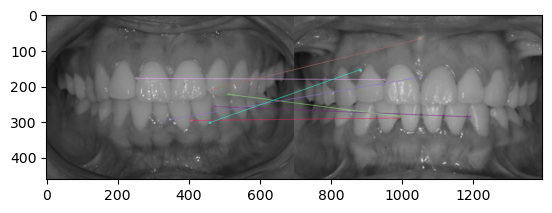

In [33]:
# ratio = 0.2 ---- 매칭 거리가 짧은 20%의 매칭점만 채택
plt.imshow(res)
plt.show()

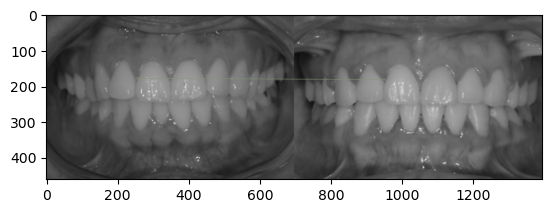

In [36]:
# ratio = 0.1 ---- 매칭 거리가 짧은 10%의 매칭점만 채택
plt.imshow(res)
plt.show()

### knnMatch() 함수
: 디스크립터당 k개의 최근접 이웃 매칭점을 가까운 순서대로 반환함
- 최근접 이웃 중 거리가 가까운 상위 몇 퍼센트만 추출한다면 좋은 매칭점을 찾아낼 수 있음

In [89]:
# ORB - 디스크립터 추출
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(b_img, None)
kp2, desc2 = detector.detectAndCompute(a_img, None)

# BF-Hamming - 매칭점 추출
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
# knnMatch - 최근접한 이웃 2개의 점에 대하여
matches = matcher.knnMatch(desc1, desc2, 5) 

ratio = 0.75
good_matches = [first for first, second in matches \
                if first.distance < second.distance * ratio]
print('matches:%d/%d' %(len(good_matches),len(matches)))

ValueError: too many values to unpack (expected 2)

In [54]:
res = cv2.drawMatches(b_img, kp1, a_img, kp2, good_matches, None, \
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

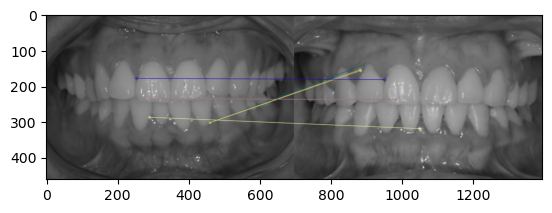

In [55]:
plt.imshow(res)
plt.show()

# cv2.findHomography
: 원래 좌표의 행렬을 '여러 매칭점으로' '근사한' 원근 변환 행렬을 구하는 함수 
* 0 (defualt) : 최소 제곱법으로 근사 계산 \
--틀린 매칭점에 대한 오차가 크게 나옴
* cv2.RANSAC(Random Sample Consensus) : 임의의 좌표만 선정하여, 만족도가 큰 것만 선정하여 근사 계산 \
--선정된 점은 정상치로 분류, 이외의 점은 이상치로 분류하여 노이즈로 판단
* cv2.LMEDS(Least Median of Squares) : 제곱의 최소 중간값을 사용하여 근사 계산\
--정상치가 50% 이상인 경우에만 정상 작동함
* cv2.RHO(Progressive Sample Consensus) : 이상치가 많은 경우에 RANSAC보다 빠름

* cv2.getPerspectiveTransform
: 원래 좌표의 행렬을 '4개의 꼭짓점으로' 정확한 원근 변환 행렬로 변환하는 함수

* cv2.perspectiveTransform
: 원근 변환할 새로운 좌표 배열을 반환함